# Machine learning
## k-Nearest Neighbor
### Theory
kNN is one of the simplest classification algorithms available for supervised learning. The idea is to search for the closest match of the test data in the feature space.  
When considering new member to add to one of two or multiple classes, one simple method is to classify to the class to which its nearest neighbor belongs. This approach has a problem that other many neighbors labelled as another class are not considered. Therefore, k nearest families are checked.  
Weighted kNN or modified kNN utilize weights to each neighbour depending on their distance.
### kNN in OpenCV

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

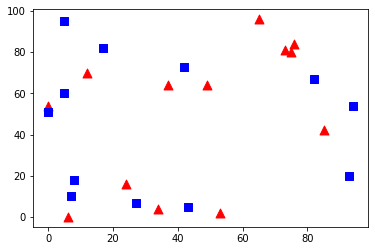

In [6]:
# feature set containing (x, y) values of 25 known/training data
trainData = np.random.randint(0, 100, (25, 2)).astype(np.float32)

# label each one with numbers 0 and 1
responses = np.random.randint(0, 2, (25, 1)).astype(np.float32)

# take red neighbors (label 0) and plot them
red = trainData[responses.ravel() == 0]
plt.scatter(red[:, 0], red[:, 1], 80, 'r', '^')

# take blue neighbors (label 1) and plot them
blue = trainData[responses.ravel() == 1]
plt.scatter(blue[:, 0], blue[:, 1], 80, 'b', 's')

plt.show()

`cv2.ml.KNearest_create()` initiate the kNN algorithm. To train, `train(samples, layout, responses)` is used and `findNearest(samples, k)` returns result label, neighbors' label, and their distance.

result: [[1.]]
neighbors: [[1. 1. 0.]]
distance: [[250. 333. 450.]]


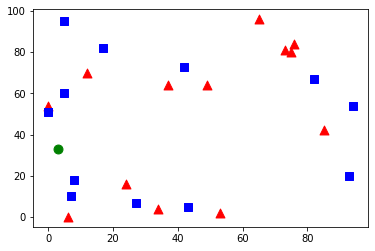

In [8]:
plt.scatter(red[:, 0], red[:, 1], 80, 'r', '^')
plt.scatter(blue[:, 0], blue[:, 1], 80, 'b', 's')

newcomer = np.random.randint(0, 100, (1, 2)).astype(np.float32)
plt.scatter(newcomer[:, 0], newcomer[:, 1], 80, 'g', 'o')

knn = cv2.ml.KNearest_create()
knn.train(trainData, cv2.ml.ROW_SAMPLE, responses)
ret, results, neighbors, dist = knn.findNearest(newcomer, 3)

print("result: {}".format(results))
print("neighbors: {}".format(neighbors))
print("distance: {}".format(dist))

plt.show()

### OCR of hand-written digits
OpenCV offers "digits.png" which has 5000 handwritten digits, each digit is a 20 x 20 image.

In [11]:
img = cv2.imread('inputs/digits.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row, 100) for row in np.vsplit(gray, 50)]

# make it into a numpy array: its size will be (50, 100, 20, 20)
x = np.array(cells)

# prepare the training data and test data (Size = (2500, 400))
train = x[:, :50].reshape(-1, 400).astype(np.float32)
test = x[:, 50:100].reshape(-1, 400).astype(np.float32)

# create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k, 250)[:, np.newaxis]  # [[0], [0], [0], ..., [9], [9], [9]]
test_labels = train_labels.copy()

# initiate kNN, train it on the training data, then test it with the test data with k=1
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)
ret, result, neighbors, dist = knn.findNearest(test, k=5)

# check the accuracy of classification
matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct * 100.0 / result.size
print(accuracy)

91.76


Application can be saved and read.

In [14]:
# save the data
np.savez('knn_data.npz', train=train, train_labels=train_labels)

# load the data
with np.load('knn_data.npz') as data:
    print(data.files)
    train = data['train']
    train_labels=data['train_labels']

['train', 'train_labels']


### OCR of the English alphabet
OpenCV comes with a data file "letter-recognition.data". In each row of the data, the first column is a letter which is label, and the next 16 numbers following it are the different features.

In [17]:
# load the data and convert the letters to numbers
data = np.loadtxt('inputs/letter-recognition.data', dtype='float32', delimiter=',', 
                                 converters={0: lambda ch: ord(ch)-ord('A')})

# split the dataset in two, with 10000 samples each for training and test sets
train, test = np.vsplit(data, 2)

# split trainData and testData into features and responses
responses, trainData = np.hsplit(train, [1])
labels, testData = np.hsplit(test, [1])

# initiate the lNN, classify, measure accuracy
knn = cv2.ml.KNearest_create()
knn.train(trainData, cv2.ml.ROW_SAMPLE, responses)
ret, result, neighbors, dist = knn.findNearest(testData, k=5)

correct = np.count_nonzero(result == labels)
accuracy = correct * 100.0 / 10000
print(accuracy)

93.06


## Support Vector Machines
### Theory
kNN measures its distance to all the training samples and take the one with minimum distance. It takes plenty of time to measure all the distances and plenty of memory. As another idea, the line which divides both the data to two regions can be found. The line is called "decision boundary".  
Plenty of such lines are possible, and taking a farthest line will provide more immunity against noise. What SVM does is to find a straight line (or hyperplane) with largest minimum distance to the training samples.

So to find decision boundary, the ones which are close to the opposite group are sufficient. One data is represented by $w^Tx + b_0 > 1$ while the other data is represented by $w^Tx + b_0 < -1$ where $w$ is weight vector and $b_0$ is the bias. The line (hyperplane) is expressed as $w^Tx + b_0 = 0$. The minimum distance from support vector to the decision boundary is given by $d = \frac{1}{\|w\|}$. Therefore, following function $L(w, b_0)$ subject to $|w^Tx+b_0| \geq 1$ should be minimized.
$$
\underset{w, b_0}{min} L(w, b_0) = \frac{1}{2} \|w\|^2
$$

### Non-linearly separable data
Sometimes data can't be divided into two with a straight line. In these cases, it may be effective that data in lower-dimensional space convert to data in higher-dimentional space.  
In addition to these concepts, the problem of misclassification errors should be considered. The new optimization problem is
$$
\underset{w, b_0}{min} L(w, b_0) =  \|w\|^2 + C\sum_i \xi_i　\mathrm{subject~to}~ t_i(w^Tx_i + b_0) \geq 1 - \xi_i \land \xi_i \geq 0~\forall i
$$
$\xi_i$ is the parameter which denotes the distance from its corresponding trainng sample to their correct decision region. the distance not misclassified is zero. The parameter C should be chosen depends on how the training data is distributed. Large values of C give solutions with less misclassification errors but a smaller margin. Small C gives the opposite.

### OCR of hand-written digits
Here, Histogram of Oriented Gradients (HOG) is used as feature vectors.  
HOG is computed as:
1. take Sobel filter.
1. the maginude and direction of gradient are computed and quantized to 16 integer values.
1. Divide the image to 4 sub-squares. For each sub-square, calculate the histogram of directions (16 bins) weighted with their magnitude.
1. 16 x 4 = 64 values  are given as a feature vector.

In [21]:
SZ = 20
bin_n = 16
affine_flags = cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR

def deskew(img):
    ''' before finding the HOG, deskew the image using its second order moments. '''
    moment = cv2.moments(img)
    if abs(moment['mu02']) < 1e-2:
        return img.copy()
    
    skew = moment['mu11'] / moment['mu02']
    matrix = np.float32([[1, skew, -0.5 * SZ * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, matrix, (SZ, SZ), flags=affine_flags)
    return img

def hog(img):
    ''' find the HOG descriptor of each cell. '''
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n * ang / (2 * np.pi))  # quantizing binvalues in (0...16)
    bin_cells = bins[:10, :10], bins[10:, :10], bins[:10, 10:], bins[10:, 10:]
    mag_cells = mag[:10, :10], mag[10:, :10], mag[:10, 10:], mag[10:, 10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)  # hist is a 64 bit vector
    return hist

img = cv2.imread('inputs/digits.png', 0)

cells = [np.hsplit(row, 100) for row in np.vsplit(img, 50)]

# first half is trainData, remaining is testData
train_cells = [i[:50] for i in cells]
test_cells = [i[50:] for i in cells]

# training
deskewed = [list(map(deskew, row)) for row in train_cells]
hogdata = [list(map(hog, row)) for row in deskewed]
trainData = np.float32(hogdata).reshape(-1, 64)
responses = np.repeat(np.arange(10), 250)[:, np.newaxis]

svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

svm.train(trainData, cv2.ml.ROW_SAMPLE, responses)
svm.save('svm_data.dat')

# testing
deskewed = [list(map(deskew, row)) for row in test_cells]
hogdata = [list(map(hog, row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1, 64)
result = svm.predict(testData)[1]

# check accuracy
mask = result==responses
correct = np.count_nonzero(mask)
print(correct * 100.0 / result.size)

93.8


## K-means clustering
### Theory
k-means clustering divides the data into k groups. This is an iterative process.
1. Algorithm randomly chooses k centroids $C_1$, ...,  $C_k$.
1. It calculates the distance from each point to all centroids. The data closest to $C_i$ is labelled with $i$.
1. It calculates the average of all labelled points for each labels and that will be new centroids.
1. 2 and 3 are iterated until all centrioids are converged (or stopped depending on maximum number of iterations or a specific accuracy is reached).

`cv2.kmeans(data, nclusters, output, criteria, attempts, flags)` returns:
- compactness: sum of squared distance from each point to their corresponding centers.
- labels: the label array
- centers: the array of centers of clusters  
"data" must be of np.float32 data type and put in a single column. "attempts" is the number of times the algorithm is executed using different initial labellings. "flags" is used to specify how initial centers are taken.

### Data with only one feature

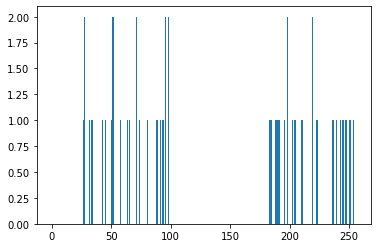

In [24]:
# create data
x = np.random.randint(25, 100, 25)
y = np.random.randint(175, 255, 25)
z = np.hstack((x, y))
z = z.reshape((50, 1))
z = np.float32(z)
plt.hist(z, 256, [0, 256])
plt.show()

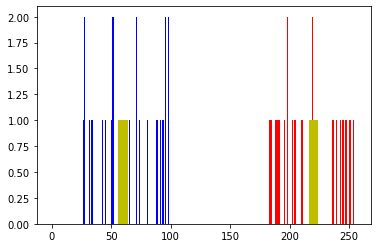

In [25]:
# define arguments
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

# apply kmeans
compactness, labels, centers = cv2.kmeans(z, 2, None, criteria, 10, flags)

A = z[labels==0]
B = z[labels==1]

plt.hist(A, 256, [0, 256], color='r')
plt.hist(B, 256, [0, 256], color='b')
plt.hist(centers, 32, [0, 256], color='y')
plt.show()

### Data with multiple features
Here, we take two features, height and weight. In this case, we set a test data of size 50x2.

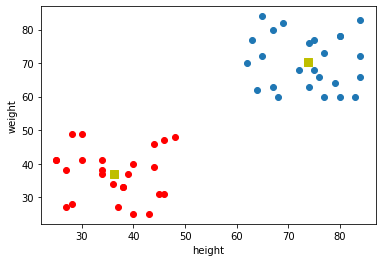

In [26]:
X = np.random.randint(25, 50, (25, 2))
Y = np.random.randint(60, 85, (25, 2))
Z = np.vstack((X, Y))
Z = np.float32(Z)

# define arguments and apply kmeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
ret, label, center = cv2.kmeans(Z, 2, None, criteria, 10, flags)

# separate the data
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]

# plot the data
plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c='r')
plt.scatter(center[:, 0], center[:, 1], s=80, c='y', marker='s')
plt.xlabel('height'), plt.ylabel('weight')
plt.show()

### Color quantization
Color quantization can reduce the memory.

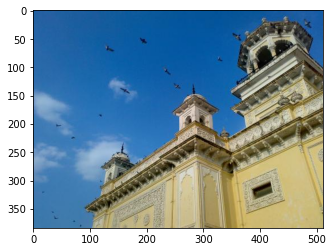

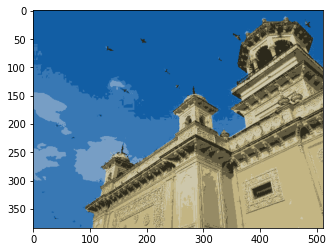

In [28]:
img = cv2.imread("inputs/home.jpeg")
Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
flags = cv2.KMEANS_RANDOM_CENTERS
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, flags)

# convert back into uint8
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res2 = cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
plt.imshow(res2)
plt.show()
